# Covid-19 analysis updated
This Python3 notebook is based on the original [Pharo Smalltalk version](https://github.com/olekscode/CovidAnalysis) by Oleksandr Zaitsev and is an update of the [August 2020 version](CovidAnalysis.ipynb). <br> The dataset for this Covid-19 analysis is publicly available and from 14 December 2020 published weekly on Thursdays. Where appropriate some code extensions have been added to view the supplied data from a different angle.

#### Disclaimer 
August 2020. To prevent inappropriate conclusions drawn on this highly actual subject:
* As a Data Science excercise this Covid-19 analysis is purely intended for educational purposes.
* The outcome of the code cells in this notebook should be regarded as the *technical* result of the code and not be interpreted otherwise.
* I have no opinion on the dataset provided nor am I responsible for possible misinterpretation of the outcome

#### Change history
**[August 2020](CovidAnalysis.ipynb)** initial version

**January 2021**: From 14 December 2020 the *European Centre for Disease Prevention and Control* for several reasons discontinued providing Covid-19 data on a daily basis. Instead weekly updates are published every Thursday. New columns in dataset are `cases_weekly` and `deaths_weekly`.

**February 2021**. Entirely rewritten due to new ECDC data dictionary: `indicator` attribute for either `cases` or `deaths` and new attribute `weekly_count`. As a result weekly counted cases and deaths are not in one record anymore.

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().

import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns #sets up styles and gives us more plotting options
import urllib.request
import pickle
import requests
import datetime

### Download latest COVID-19 data
Download the latest COVID-19 data from the [European Centre for Disease Prevention](https://www.ecdc.europa.eu/en/publications-data/data-national-14-day-notification-rate-covid-19).

In [2]:
def dataCsvURL():
    return 'https://opendata.ecdc.europa.eu/covid19/nationalcasedeath/csv'

In [3]:
def dataDirectory():
    return 'data/'

In [4]:
def dataCsvFile():
    return dataDirectory() + 'covidDataWeekly.csv'

In [5]:
#Let's give it a try and save to CSV file
covidFile = requests.get(dataCsvURL())
open(dataCsvFile(), 'wb').write(covidFile.content)

2761966

### Read and clean data
Now read the data from the CSV file into a dataframe using pandas. Clean up to show the relevant columns.

In [6]:
def columnsToDisplay():
    return['year_week', 'indicator', 'weekly_count', 'country', 'population' ]

In [7]:
# Convert population to integer. Caution: astype(int) gives error "Cannot convert non-finite values (NA or inf) to integer"
def preProcessing(df):
    df['population'] = df['population'].astype('Int64')

In [8]:
df = pd.read_csv(dataCsvFile(), usecols=columnsToDisplay())
preProcessing(df)
df.sort_values(by=['year_week', 'country'], ascending=False).head(20)

,country,population,indicator,weekly_count,year_week
22269,the Holy See/ Vatican City State,809,cases,0,2021-11
22323,the Holy See/ Vatican City State,809,deaths,0,2021-11
24558,Zimbabwe,14862927,cases,181,2021-11
24611,Zimbabwe,14862927,deaths,9,2021-11
24452,Zambia,18383956,cases,1738,2021-11
24505,Zambia,18383956,deaths,24,2021-11
24349,Yemen,29825968,cases,582,2021-11
24399,Yemen,29825968,deaths,62,2021-11
24251,Western Sahara,597330,cases,0,2021-11
24299,Western Sahara,597330,deaths,0,2021-11


#### One country
The core of western civilization and a popular holiday destination:

In [9]:
df.query("country == 'Greece'").sort_values(by=['year_week'], ascending=False).head(10)

,country,population,indicator,weekly_count,year_week
9377,Greece,10718565,deaths,371,2021-11
9313,Greece,10718565,cases,15978,2021-11
9312,Greece,10718565,cases,16027,2021-10
9376,Greece,10718565,deaths,333,2021-10
9311,Greece,10718565,cases,14020,2021-09
9375,Greece,10718565,deaths,254,2021-09
9310,Greece,10718565,cases,11298,2021-08
9374,Greece,10718565,deaths,207,2021-08
9373,Greece,10718565,deaths,171,2021-07
9309,Greece,10718565,cases,7674,2021-07


### Top 10 countries of reported cases  (in numbers)
This is an aggregate action on the dataframe. As a beginner in Data science and Pandas I find it cumbersome to get these top 10 countries of reported cases. IMO **Pharo's Smalltalk** solution below is much cleaner and easier to understand.

```
(df group: 'cases' by: 'country' aggregateUsing: #sum)
	sortDescending
	head: 10.
```

To find the 10 countries having the least reported cases simply replace `head` by `tail`. <br><br> February 2021: totals for continents and EU are excluded.

In [10]:
gPerCountry = df.groupby('country')
casesPerCountry = gPerCountry.apply(lambda x: x[x['indicator'] == 'cases']['weekly_count'].sum())
print(type(casesPerCountry))
casesPerCountry=casesPerCountry.drop(labels=['Oceania (total)', 'America (total)', 'Europe (total)', 'EU/EEA (total)','Africa (total)', 'Asia (total)'])
sortedCasesPerCountry = casesPerCountry.sort_values(ascending=False)
sortedCasesPerCountry.head(20)

<class 'pandas.core.series.Series'>


country
United States     29819108
Brazil            12047526
India             11646081
Russia             4466153
United Kingdom     4296583
France             4282603
Italy              3376376
Spain              3228803
Turkey             3013122
Germany            2667225
Colombia           2342278
Argentina          2245717
Mexico             2197160
Poland             2073129
Iran               1801065
Ukraine            1554256
South Africa       1537852
Peru               1472790
Czechia            1467333
Indonesia          1460184
dtype: int64

### Top 10 countries of reported cases  (relative population)
Another approach is to collect the number of cases in a country relative to the population.

In [11]:
# Find 10 countries with relatively highest cases
gPerCountry = df.groupby('country')

casesPerCountry = gPerCountry.apply(lambda x: x[x['indicator'] == 'cases']['weekly_count'].sum())
populationPerCountry = df.groupby('country').mean()[['population']]
populationPerCountry['cases weekly (%)']=casesPerCountry / populationPerCountry['population'] * 100
populationPerCountry.sort_values(by=['cases weekly (%)'], ascending=False).head(10)

,population,cases weekly (%)
country,,
Andorra,76177,15.155493
Montenegro,621873,14.024085
Czechia,10693939,13.721165
Gibraltar,33691,12.674008
San Marino,34453,12.643311
Slovenia,2095861,9.844021
Israel,8655541,9.568888
Luxembourg,626108,9.489737
United States,331002647,9.008722


### Top 10 countries of reported deaths (in numbers)
To find the 10 countries having the least reported Covid-19 deaths (cumulative) simply replace `head` by `tail`. <br><br> February 2021: totals for continents and EU are excluded.

In [12]:
gPerCountry = df.groupby('country')
deathsPerCountry = gPerCountry.apply(lambda x: x[x['indicator'] == 'deaths']['weekly_count'].sum())
deathsPerCountry=deathsPerCountry.drop(labels=['Oceania (total)', 'America (total)', 'Europe (total)', 'EU/EEA (total)','Africa (total)', 'Asia (total)'])
sortedDeathsPerCountry = deathsPerCountry.sort_values(ascending=False)
sortedDeathsPerCountry.head(20)


country
United States     542359
Brazil            295425
Mexico            198239
India             159967
United Kingdom    126155
Italy             104942
Russia             95391
France             92305
Germany            74714
Spain              73543
Colombia           62148
Iran               61797
Argentina          54545
South Africa       52111
Peru               50339
Poland             49365
Indonesia          39550
Ukraine            30098
Turkey             30061
Czechia            24810
dtype: int64

### Top 10 countries of reported deaths  (relative population)
Another approach is to collect the number of deaths in a country relative to the population.

In [13]:
# Find 10 countries with relatively highest deaths
gPerCountry = df.groupby('country')
deathsPerCountry = gPerCountry.apply(lambda x: x[x['indicator'] == 'deaths']['weekly_count'].sum())
populationPerCountry = df.groupby('country').mean()[['population']]
populationPerCountry['deaths weekly (%)']=deathsPerCountry / populationPerCountry['population'] * 100
populationPerCountry.sort_values(by=['deaths weekly (%)'], ascending=False).head(10)

,population,deaths weekly (%)
country,,
Gibraltar,33691,0.279006
Czechia,10693939,0.232001
San Marino,34453,0.229298
Slovenia,2095861,0.203210
Belgium,11522440,0.197224
Montenegro,621873,0.192805
Hungary,9769526,0.188863
United Kingdom,68059863,0.185359
Bosnia and Herzegovina,3280815,0.175962


### Covid-19 spread in The Netherlands

In [14]:
df_country = df[df.country=='Netherlands']
relevant_columns = ['year_week', 'indicator', 'weekly_count']
covid_df_country = df_country[relevant_columns]
covid_df_country.sort_values(by=['year_week'], ascending=False).head(10)

,year_week,indicator,weekly_count
15997,2021-11,deaths,203
15933,2021-11,cases,45084
15932,2021-10,cases,38713
15996,2021-10,deaths,225
15931,2021-09,cases,31428
15995,2021-09,deaths,277
15930,2021-08,cases,31613
15994,2021-08,deaths,334
15993,2021-07,deaths,405
15929,2021-07,cases,28657


### Max weekly cases in The Netherlands
Find the week when most cases were reported

In [15]:
maxWeeklyCases = covid_df_country['weekly_count'].max()
covid_df_country[(covid_df_country.weekly_count==maxWeeklyCases)]


,year_week,indicator,weekly_count
15921,2020-52,cases,80594


### Max weekly deaths in The Netherlands
Find the week when most deaths were reported

In [16]:
gPerCountry = covid_df_country.groupby('indicator')
deaths = gPerCountry.apply(lambda x: x[x['indicator'] == 'deaths']['weekly_count'].max())
covid_df_country[(covid_df_country.weekly_count==deaths.deaths)]


,year_week,indicator,weekly_count
15947,2020-14,deaths,995


### Cumulative sum of cases and deaths
To find the total number of reported cases and deaths up to a date in the Netherlands

In [17]:
def compressed_country_df(df):
    gPerCountry = df.groupby('indicator')
    cases = gPerCountry.apply(lambda x: x[x['indicator'] == 'cases']['weekly_count']).values
    deaths = gPerCountry.apply(lambda x: x[x['indicator'] == 'deaths']['weekly_count']).values
    names = gPerCountry.apply(lambda x: x[x['indicator'] == 'deaths']['country']).values
    population = gPerCountry.apply(lambda x: x[x['indicator'] == 'deaths']['population']).values
    cumulativeCases = gPerCountry.apply(lambda x: x[x['indicator'] == 'cases']['weekly_count'].cumsum(axis = 0)).values
    cumulativeDeaths = gPerCountry.apply(lambda x: x[x['indicator'] == 'deaths']['weekly_count'].cumsum(axis = 0)).values
    df_new = pd.DataFrame()
    df_new['country'] = names
    df_new['population'] = population
    df_new['year_week'] = df['year_week'].unique()
    df_new['cases_weekly'] = cases
    df_new['deaths_weekly'] = deaths
    df_new['cumulative_cases'] = cumulativeCases
    df_new['cumulative_deaths'] = cumulativeDeaths
    return df_new

In [18]:
df_country = df[df.country=='Netherlands']
dfNL=compressed_country_df(df_country)
dfNL.sort_values(by=['year_week'], ascending=False).head(20)

,country,population,year_week,cases_weekly,deaths_weekly,cumulative_cases,cumulative_deaths
63,Netherlands,17407585,2021-11,45084,203,1206281,16270
62,Netherlands,17407585,2021-10,38713,225,1161197,16067
61,Netherlands,17407585,2021-09,31428,277,1122484,15842
60,Netherlands,17407585,2021-08,31613,334,1091056,15565
59,Netherlands,17407585,2021-07,28657,405,1059443,15231
58,Netherlands,17407585,2021-06,24069,414,1030786,14826
57,Netherlands,17407585,2021-05,26270,403,1006717,14412
56,Netherlands,17407585,2021-04,28671,445,980447,14009
55,Netherlands,17407585,2021-03,35590,522,951776,13564
54,Netherlands,17407585,2021-02,38967,645,916186,13042


### Reported cases and deaths in the Netherlands
How is Covid-19 moving in time? This plot merely prints the weekly figures. The whereabouts of the data should be given before any conclusion may be drawn. E.g. consider the fact that the test capacity is now considerably higher than after the outbreak of the virus and has an important impact on the number of reported contaminations. However the number of confirmed deaths might be a more reliable indicator.

Text(0, 0.5, 'Weekly Count')

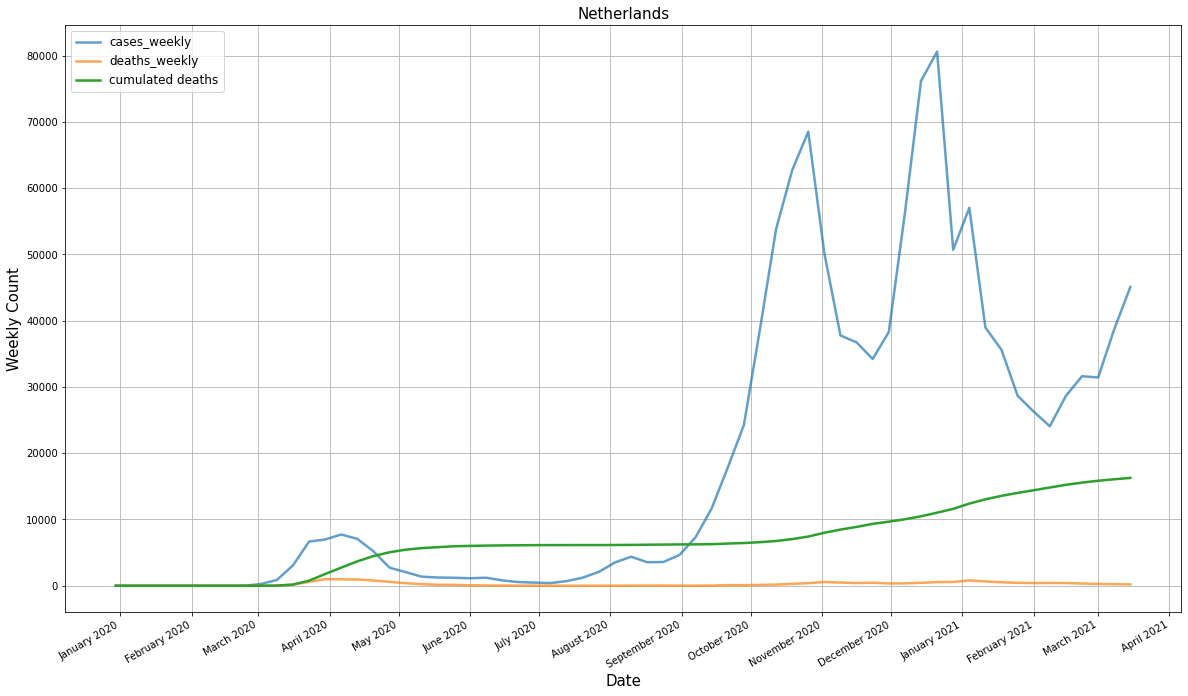

In [19]:
plt.figure(figsize=(20,12))
for i in ['cases_weekly', 'deaths_weekly']: 
    #convert strings to dates. All weeks starting on Monday. Week numbering follows ISO week date standard (ISO-8601).
    x = [datetime.datetime.strptime(d + '-1', "%G-%V-%u") for d in dfNL.year_week.values]
    plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%B %Y'))
    plt.gca().xaxis.set_major_locator(mpl.dates.MonthLocator())
    plt.plot(x, dfNL[i], alpha=0.7, label=i, linewidth='2.5')
    plt.gcf().autofmt_xdate()

plt.plot (x, dfNL['cumulative_deaths'], label='cumulated deaths', linewidth='2.5')
plt.legend(loc="upper left", prop={'size': 12})
plt.grid()
plt.title('Netherlands', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Weekly Count', fontsize=15)

### Plot data several countries
For some European countries the weekly reported deaths are plotted in absolute numbers, relative to the population and cumulated. Justification country choice:
* Italy => first European country hit by Covid-19
* United_Kingdom => British variant of Covid-19
* Austria and Poland => comparatively small effect in 1st wave
* Belgium => comparatively high effect in 1st wave
* Netherlands => where I live

Change the `countries` list to show other countries.

#### Absolute numbers

Text(0, 0.5, 'Count')

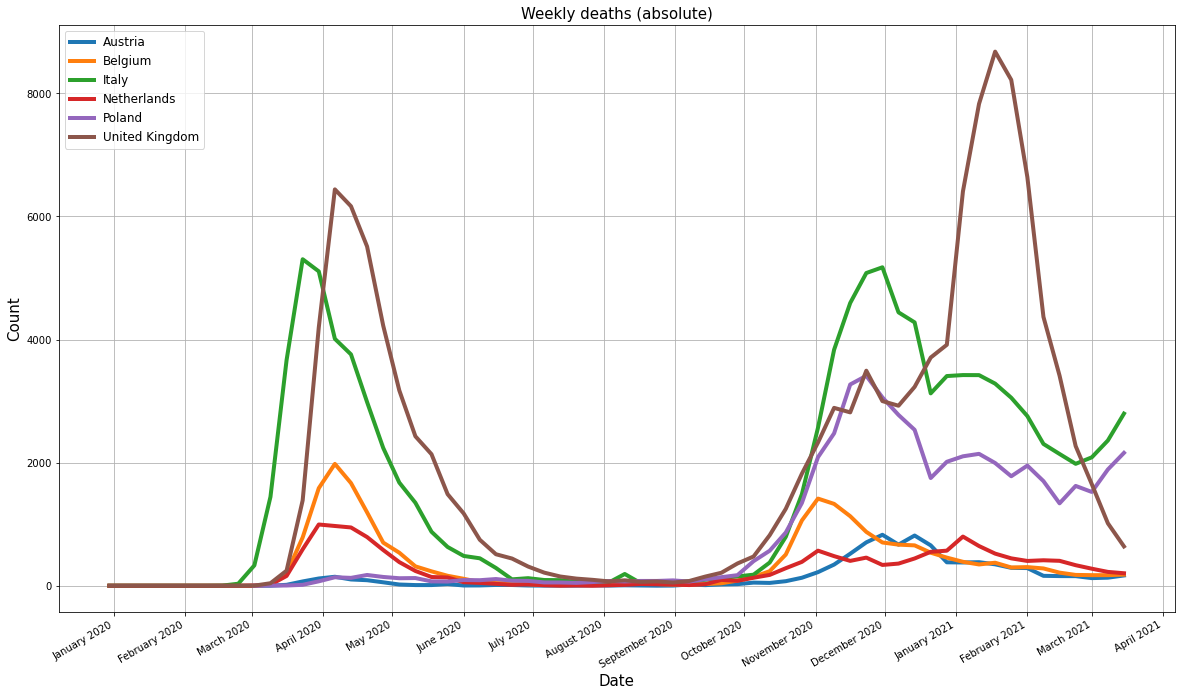

In [20]:
countries = ['Austria', 'Belgium', 'Italy', 'Netherlands', 'Poland', 'United Kingdom']
df_countries = [df[df.country==country] for country in countries]
dfs=[compressed_country_df(df) for df in df_countries]
plt.rcParams["figure.figsize"] = [20,12]
for covid_df_country in dfs:
    lbl = next(iter(set(covid_df_country.country.values))) 
    x = [datetime.datetime.strptime(d + '-1', "%G-%V-%u") for d in covid_df_country.year_week.values] #convert strings to dates
    plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%B %Y'))
    plt.gca().xaxis.set_major_locator(mpl.dates.MonthLocator())
    plt.plot(x, covid_df_country.deaths_weekly, alpha=1.0, label=lbl, linewidth=4.0)
    plt.gcf().autofmt_xdate()
    plt.legend(loc="upper left",  prop={'size': 12})
plt.grid()
plt.title('Weekly deaths (absolute)', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)


#### Relative population

Text(0, 0.5, 'Count')

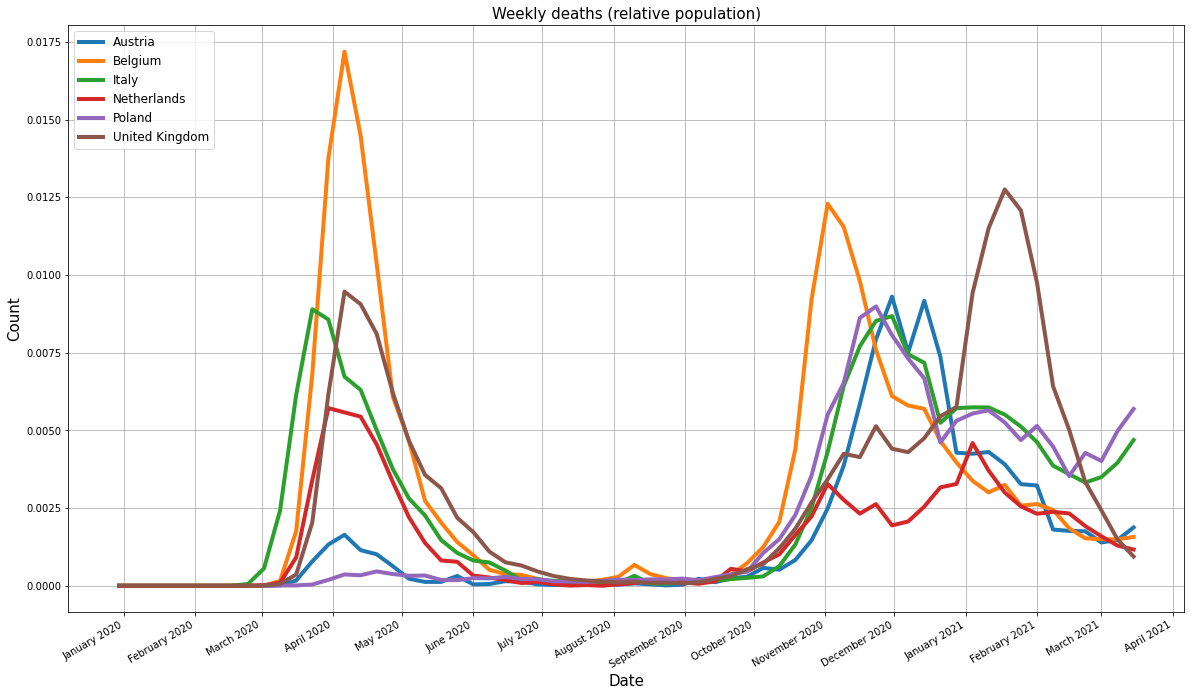

In [21]:
plt.rcParams["figure.figsize"] = [20,12]
for covid_df_country in dfs:
    lbl = next(iter(set(covid_df_country.country.values))) 
    x = [datetime.datetime.strptime(d + '-1', "%G-%V-%u") for d in covid_df_country.year_week.values] #convert strings to dates
    plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%B %Y'))
    plt.gca().xaxis.set_major_locator(mpl.dates.MonthLocator())
    y = covid_df_country.deaths_weekly / covid_df_country.population * 100
    plt.plot(x, y , alpha=1.0, label=lbl, linewidth=4.0)
    plt.gcf().autofmt_xdate()
    plt.legend(loc="upper left",  prop={'size': 12})
plt.grid()
plt.title('Weekly deaths (relative population)', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)

#### Cumulated

Text(0, 0.5, 'Count')

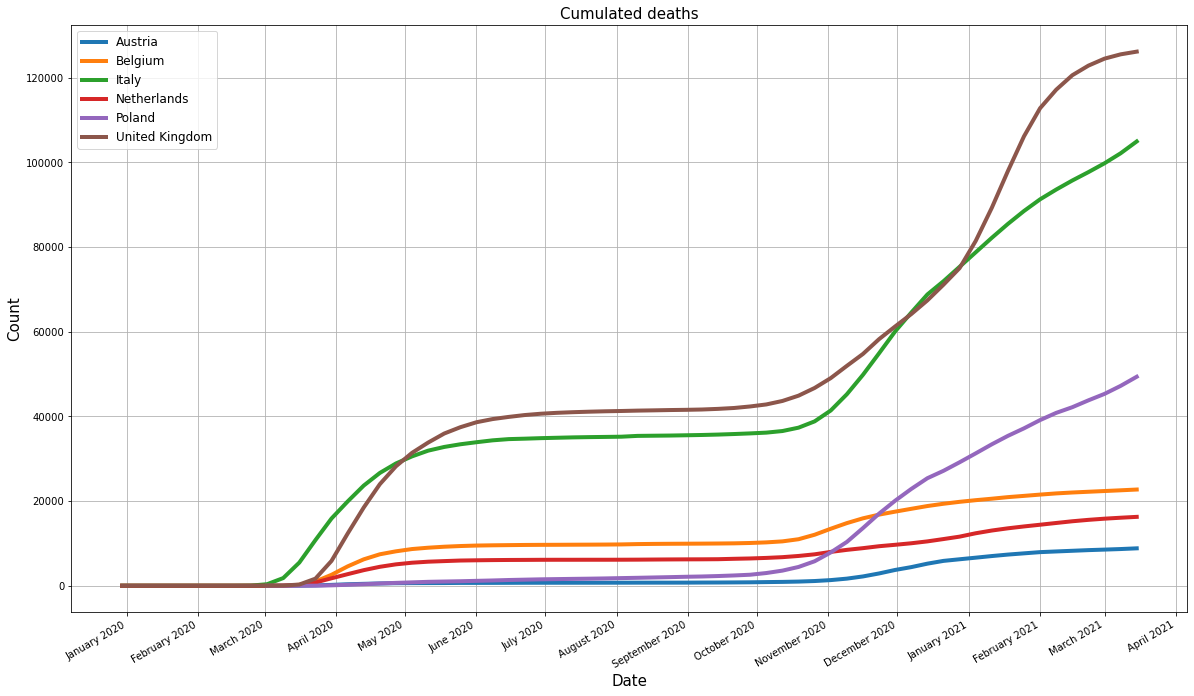

In [22]:
plt.rcParams["figure.figsize"] = [20,12]
for covid_df_country in dfs:
    lbl = next(iter(set(covid_df_country.country.values))) 
    x = [datetime.datetime.strptime(d + '-1', "%G-%V-%u") for d in covid_df_country.year_week.values] #convert strings to dates
    plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%B %Y'))
    plt.gca().xaxis.set_major_locator(mpl.dates.MonthLocator())
    plt.plot(x, covid_df_country['cumulative_deaths'], alpha=1.0, label=lbl, linewidth=4.0)
    plt.gcf().autofmt_xdate()
    plt.legend(loc="upper left", prop={'size': 12})
plt.grid()
plt.title('Cumulated deaths', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)

#### Visualisation in Tableau Public
February 2021: the Tableau Public dashboard reflects the situation up to 08-02-2021.<br><br>If the Tableau visualisation doesn't show up, try it in [Jupyter's nbviewer](https://nbviewer.jupyter.org/github/HodaAtWork/DS-miniatures/blob/master/Python/CovidAnalysisUpdated.ipynb).

In [25]:
%%html
<div class='tableauPlaceholder' id='viz1612728645244' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Mo&#47;MortalilityrateCovid-19ECDC&#47;Deaths-Covid-19&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='MortalilityrateCovid-19ECDC&#47;Deaths-Covid-19' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Mo&#47;MortalilityrateCovid-19ECDC&#47;Deaths-Covid-19&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1612728645244');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='1727px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>